# CMU Movie Summary Corpus
Este notebook realiza a classificação multi-label dos gêneros dos filmes com base em suas sinopses.

Os dados são provenientes do CMU Movie Summary Corpus, que consiste em metadados e sinopses de filmes.

Neste notebook, vamos testar dois algoritmos de classificação diferentes:
*   **RandomForestClassifier**
*   **DecisionTreeClassifier**

Ambos serão usados para classificar as sinopses dos filmes em múltiplos gêneros.


# 1 - Carregar os dados
Essa seção aborda questões de importação e carregamento dos dados utilizados nesse projeto.


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

A seguir, serão importados e carregados para um dataframe os dois datasets referentes respectivamente a:

*   movie.metadata: Dados referentes a filmes, como título, ano e línguas;
*   plot_summaries: Dados referentes a sinopses dos filmes

In [2]:
metadata_path = "movie.metadata.tsv"
plot_summaries_path = "plot_summaries.txt"

In [3]:
metadata_path

'movie.metadata.tsv'

In [4]:
metadata = pd.read_csv(metadata_path, sep='\t', header=None)
metadata.columns = ["movie_id", "freebase_id", "movie_name",
                    "movie_release_date", "movie_revenue",
                    "movie_runtime", "movie_languages", "movie_countries",
                    "movie_genres"]

In [5]:
plot_summaries = pd.read_csv(plot_summaries_path, sep='\t', header=None)
plot_summaries.columns = ["movie_id", "plot_summary"]

Seguindo para a agregação dos dois dataframes, vinculados pela coluna "movie_id"

In [6]:
movies = pd.merge(metadata, plot_summaries, on="movie_id")

# 2 - Análise Exploratória
Essa seção aborda a realização de uma análise exploratória e através dela nos permite que:


1.   Visualizarmos as primeiras linhas dos dados para entender sua estrutura.
2.   Calcularmos estatísticas descritivas, como média, mínimo e máximo, para variáveis numéricas, como a duração dos filmes.
3.   Contarmos o número de filmes por gênero e exibimos a distribuição dessa contagem.

In [7]:
print("Número total de filmes no conjunto de dados:", len(movies))

Número total de filmes no conjunto de dados: 42204


 Visualizar as primeiras linhas dos dados

In [8]:
print("### Amostra dos Dados ###")
print(movies.head())
print()


### Amostra dos Dados ###
   movie_id freebase_id                 movie_name movie_release_date  \
0    975900   /m/03vyhn             Ghosts of Mars         2001-08-24   
1   9363483  /m/0285_cd           White Of The Eye               1987   
2    261236   /m/01mrr1          A Woman in Flames               1983   
3  18998739  /m/04jcqvw  The Sorcerer's Apprentice               2002   
4   6631279   /m/0gffwj                Little city         1997-04-04   

   movie_revenue  movie_runtime                     movie_languages  \
0     14010832.0           98.0  {"/m/02h40lc": "English Language"}   
1            NaN          110.0  {"/m/02h40lc": "English Language"}   
2            NaN          106.0   {"/m/04306rv": "German Language"}   
3            NaN           86.0  {"/m/02h40lc": "English Language"}   
4            NaN           93.0  {"/m/02h40lc": "English Language"}   

                             movie_countries  \
0  {"/m/09c7w0": "United States of America"}   
1           

Entendendo a estrutura dos dados


In [9]:
print(movies.dtypes)

movie_id                int64
freebase_id            object
movie_name             object
movie_release_date     object
movie_revenue         float64
movie_runtime         float64
movie_languages        object
movie_countries        object
movie_genres           object
plot_summary           object
dtype: object


Estatísticas descritivas


In [10]:
print(movies.describe())
print()

           movie_id  movie_revenue  movie_runtime
count  4.220400e+04   7.587000e+03   3.558000e+04
mean   1.495709e+07   5.175973e+07   1.285403e+02
std    1.111620e+07   1.167179e+08   5.721460e+03
min    3.300000e+02   1.020000e+04   3.000000e-01
25%    4.559790e+06   2.500000e+06   8.600000e+01
50%    1.282482e+07   1.242118e+07   9.600000e+01
75%    2.482497e+07   4.559722e+07   1.100000e+02
max    3.750192e+07   2.782275e+09   1.079281e+06



Contagem de filmes por gênero



In [11]:
genre_counts = movies["movie_genres"].apply(lambda x: len(eval(x))).value_counts()
print(genre_counts)
print()

movie_genres
1     8424
2     7440
3     7053
4     6211
5     4497
6     3326
7     2222
8     1249
9      725
0      411
10     356
11     166
12      70
13      36
14      11
15       5
16       1
17       1
Name: count, dtype: int64



Distribuição dos Gêneros dos Filmes

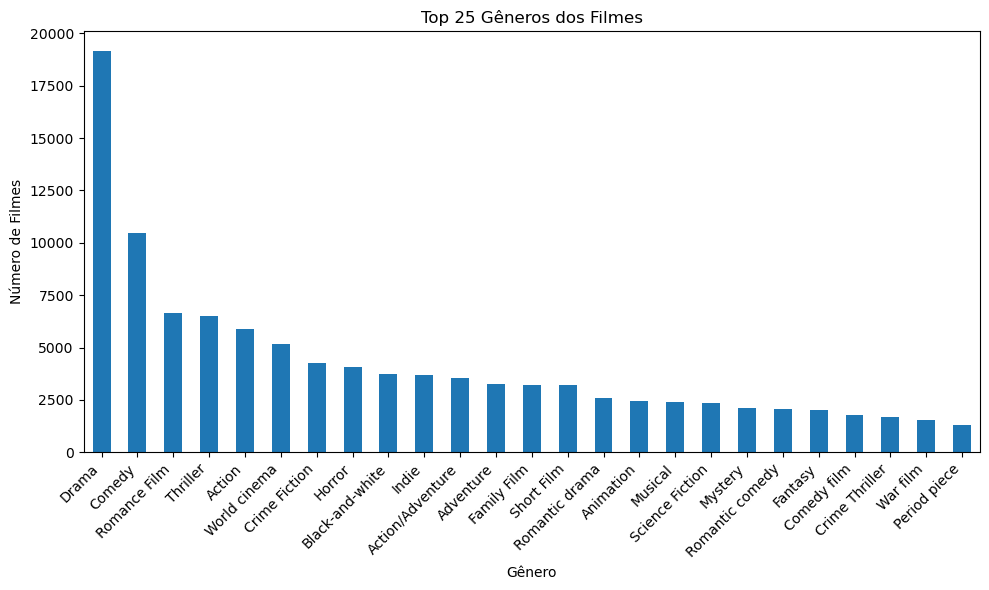

In [12]:
genres = []
for genre_list in movies["movie_genres"]:
    genre_dict = eval(genre_list)
    genre_names = [genre_name for genre_id, genre_name in genre_dict.items()]
    genres.extend(genre_names)

genre_distribution = pd.Series(genres).value_counts()

# Filtrar para trazer apenas os 10 gêneros mais frequentes
top_25_genres = genre_distribution.head(25)

# Plotar gráfico de barras
plt.figure(figsize=(10, 6))
top_25_genres.plot(kind='bar')
plt.title('Top 25 Gêneros dos Filmes')
plt.xlabel('Gênero')
plt.ylabel('Número de Filmes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 3 - Pré-Processamento

Essa seção aborda o Pré-Processamento e transformação dos dados para treinamento.

Foi identificado uma necessidade de extrair os gêneros como rótulos e as sinopses dos filmes como dados de entrada, no intuito de transforma-los para serem utilizados na próxima etapa.

In [13]:
genres = []
for genre_list in movies["movie_genres"]:
    genre_dict = eval(genre_list)  # Avalia a string como um dicionário
    genre_names = [genre_name for genre_id, genre_name in genre_dict.items()]
    genres.append(genre_names)

In [14]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(genres)
genre_labels = mlb.classes_

# 4 - Treinamento e Classificação

Nessa seção descreve a criação e treinamento dos modelos de classificação para o proposto projeto



Em seguida, dividiremos os dados em conjuntos de treinamento e teste.

O parâmetro **test_size** define a proporção do conjunto de dados que será reservada para o conjunto de teste.

Neste caso, test_size=0.2 significa que 20% dos dados serão usados como conjunto de teste, enquanto os restantes 80% serão usados como conjunto de treinamento.

Já o parâmetro **random_state** é usado para controlar a aleatoriedade na divisão dos dados em conjuntos de treinamento e teste. Ao definir um valor específico para random_state, você garante que a divisão dos dados será reproduzível.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(movies["plot_summary"], y, test_size=0.2, random_state=42)

## 4.1 - Treinamento e Classificação RandomForestClassifier

O RandomForestClassifier é um algoritmo de aprendizado que pode ser usado tanto para classificação quanto para regressão.

É baseado em ensemble que constrói várias árvores de decisão aleatórias e combina suas previsões.

Em sequencia, será iniciado a construção do pipeline de classificação com RandomForest


In [16]:
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

Seguido pelo treinamento do Modelo

In [17]:
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

E finalizando com a avaliação do modelo


In [18]:
y_pred_rf = pipeline_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names=genre_labels))

                                          precision    recall  f1-score   support

                               Absurdism       0.00      0.00      0.00        18
                            Acid western       0.00      0.00      0.00         2
                                  Action       0.70      0.01      0.02      1168
                           Action Comedy       0.00      0.00      0.00        34
                        Action Thrillers       0.00      0.00      0.00        75
                        Action/Adventure       0.00      0.00      0.00       677
                         Addiction Drama       0.00      0.00      0.00         8
                                   Adult       0.00      0.00      0.00        19
                               Adventure       0.00      0.00      0.00       625
                        Adventure Comedy       0.00      0.00      0.00        20
                  Airplanes and airports       0.00      0.00      0.00        13
               

C:\Users\Pe4\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pe4\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pe4\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pe4\anaconda3\Lib\site-packages\sklearn\metrics\_classificat

## 4.2 - Treinamento e Classificação DecisionTreeClassifier


O DecisionTreeClassifier é um algoritmo de aprendizado de máquina supervisionado usado principalmente para tarefas de classificação. Ele cria uma árvore de decisão que modela as decisões com base nos recursos de entrada fornecidos.

A seguir, será iniciado a construção do pipeline de classificação com DecisionTreeClassifier


In [19]:
pipeline_dt = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', MultiOutputClassifier(DecisionTreeClassifier()))
])

Seguido pelo treinamento do Modelo

In [20]:
pipeline_dt.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf',
                 MultiOutputClassifier(estimator=DecisionTreeClassifier()))])

E finalizando com a avaliação do modelo


In [21]:
y_pred_dt = pipeline_dt.predict(X_test)
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_dt, target_names=genre_labels))

Relatório de Classificação:


C:\Users\Pe4\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pe4\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                          precision    recall  f1-score   support

                               Absurdism       0.00      0.00      0.00        18
                            Acid western       0.00      0.00      0.00         2
                                  Action       0.33      0.32      0.32      1168
                           Action Comedy       0.06      0.03      0.04        34
                        Action Thrillers       0.13      0.11      0.12        75
                        Action/Adventure       0.22      0.22      0.22       677
                         Addiction Drama       0.00      0.00      0.00         8
                                   Adult       0.11      0.16      0.13        19
                               Adventure       0.25      0.24      0.25       625
                        Adventure Comedy       0.00      0.00      0.00        20
                  Airplanes and airports       0.20      0.08      0.11        13
               

C:\Users\Pe4\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Pe4\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 5 - Teste dos Modelos de Classificação
Essa seção seguira com testes do modelo de classificação em uma sinopse de filme de exemplo.

Para isso, foram selecionados 3 filmes e forneceremos uma sinopse de filme como entrada para o modelo treinado e examinaremos os gêneros previstos pelo modelo.



Aqui está um exemplo de uma sinopse de filme em inglês:

" In 1936, archaeologist Indiana Jones braves an ancient Peruvian temple filled with booby traps to retrieve a golden idol. Upon fleeing the temple, Indiana is confronted by rival archaeologist René Belloq and the indigenous Hovitos..."

Vamos alimentar essa sinopse para o modelo e ver quais gêneros o modelo prevê para este filme.

A função a seguir descreve como o usuário irá inserir os dados que serão passados ao modelo e retornados em tela.

In [22]:
def predict_movie_genre(title, plot_summary, model, mlb):
    # Prever os gêneros do filme
    prediction = model.predict([plot_summary])

    # Decodificar as previsões de volta para os rótulos de gênero
    predicted_genres = mlb.inverse_transform(prediction)

    # Imprimir os gêneros previstos
    print("Gêneros previstos para o filme '{}':".format(title))
    for genre in predicted_genres[0]:
        print(genre)

## Exemplo 1 - Indiana Jones: Os Caçadores da Arca Perdida



Declaração do filme selecionado


In [23]:
movie_title = "Indiana Jones: Raiders of the Lost Ark"
movie_plot_summary = ("In 1936, archaeologist Indiana Jones braves an ancient Peruvian temple filled with booby traps to retrieve a golden idol. Upon fleeing the temple, Indiana is confronted by rival archaeologist René Belloq and the indigenous Hovitos. Surrounded and outnumbered, Indiana is forced to surrender the idol to Belloq and escapes aboard a waiting Waco seaplane, in the process revealing his fear of snakes. Shortly after returning to the college in the United States where he teaches archaeology, Indiana is interviewed by two Army intelligence agents. They inform him that the Nazis, in their quest for occult power, are searching for his old mentor, Abner Ravenwood, who is the leading expert on the ancient Egyptian city of Tanis and possesses the headpiece of an artifact called the Staff of Ra. Indiana deduces that the Nazis are searching for Tanis because it is believed to be the location of the Ark of the Covenant, the biblical chest built by the Israelites to contain the fragments of the Ten Commandments; the Nazis believe that if they acquire it, their armies will become invincible. The Staff of Ra, meanwhile, is the key to finding the Well of Souls, a secret chamber in which the Ark is buried. The agents subsequently authorize Indiana to recover the Ark before the Nazis. Indiana travels to Nepal, only to find that Ravenwood has died and that the headpiece is in the possession of his daughter, Marion, Indiana's embittered former lover. Indiana offers to buy the headpiece for three thousand dollars, plus two thousand more when they return to the United States. Marion's tavern is suddenly raided by a group of thugs commanded by Nazi agent Toht. The tavern is burned down in the ensuing fight, during which Toht burns his hand on the searing hot headpiece as he tries to grab it. Indiana and Marion escape with the headpiece, with Marion declaring she will accompany Indiana in his search for the Ark so he can repay his debt. They travel to Cairo where they learn from Indiana's friend Sallah, a skilled excavator, that Belloq and the Nazis, led by Colonel Dietrich, are currently digging for the Well of Souls with a replica of the headpiece modeled after the scar on Toht's hand. In a bazaar, Nazi operatives attempt to kidnap Marion and as Indiana chases after them it appears that she dies in an explosion. While deciphering the markings on the headpiece, Indiana and Sallah realize that the Nazis have miscalculated the location of the Well of Souls. Using this to their advantage, they infiltrate the Nazi dig and use the Staff of Ra to determine the location correctly and uncover the Well of Souls, which is filled with snakes. Indiana fends off the snakes and acquires the Ark, but Belloq, Dietrich and the Nazis arrive to take it. They toss Marion into the well with Indiana and seal them in, but they manage to escape. After a fistfight with a giant Nazi mechanic, blowing up a flying wing on the airstrip, and chasing down a convoy of trucks, Indiana takes back the Ark before it can be shipped to Berlin. Indiana and Marion leave Cairo to escort the Ark to England on board a tramp steamer. The next morning, their boat is boarded by Belloq, Dietrich and the Nazis, who once again steal the Ark and kidnap Marion. Indiana stows away on their U-boat and follows them to an isolated island in the Aegean Sea where Belloq plans to test the power of the Ark before presenting it to Hitler. Indiana reveals himself and threatens to destroy the Ark with a rocket-propelled grenade launcher, but Belloq calls his bluff, knowing Indy cannot bear to eradicate an important historical artifact. Indiana surrenders and is tied to a post with Marion as Belloq performs a ceremonial opening of the Ark, which appears to contain nothing but sand. Suddenly, spirits resembling Old Testament Seraphim emerge from the Ark. Aware of the supernatural danger of looking at the opened Ark, Indiana warns Marion to close her eyes. The apparitions suddenly morph into angels of death, and lightning bolts begin flying out of the Ark, gruesomely killing the Nazi soldiers, while Belloq, Dietrich and Toht meet even more gruesome fates. The fires rise into the sky, then fall back down to Earth and the Ark closes with a crack of thunder. Back in Washington, D.C., the Army intelligence agents tell a suspicious Indiana and Brody that the Ark is someplace safe to be studied by top men. In reality, the Ark is sealed in a wooden crate labeled top secret and stored in a giant government warehouse filled with countless similar crates.")

Retorno do modelo

In [24]:
predict_movie_genre(movie_title, movie_plot_summary, pipeline_rf, mlb)

Gêneros previstos para o filme 'Indiana Jones: Raiders of the Lost Ark':
Action
Action/Adventure
Adventure
Airplanes and airports
Costume Adventure
New Hollywood


In [25]:
predict_movie_genre(movie_title, movie_plot_summary, pipeline_dt, mlb)

Gêneros previstos para o filme 'Indiana Jones: Raiders of the Lost Ark':
Action
Action/Adventure
Adventure
Airplanes and airports
Costume Adventure
New Hollywood


## Exemplo 2 - A Origem

Declaração do filme selecionado


In [26]:
movie_title = "Inception"
movie_plot_summary = ("Former dream architect Dominick Dom Cobb  and business partner Arthur  perform corporate espionage by using an experimental military-developed machine to infiltrate the subconscious of their targets and extract information while dreaming, their latest target being powerful Japanese businessman Saito . Tiered dream within a dream strategies are used and dreamers awaken by a sudden kick or by dying in the dream. However, if the dreamer is the one who dies, the dream collapses. Each extractor carries a totem, a personalized small object whose behavior is only predictable to its owner, that serves the purpose of identifying dream-state or reality. Cobbs totem is a spinning top that perpetually spins in the dream state. The extraction fails due to Mallorie Mal Cobb , Cobbs deceased wife, whose memory projection sabotages the mission. Saito later reveals, after Cobbs and Arthurs associate  sells them out, that he was in fact auditioning the team to perform the difficult act of inception: implanting an idea or thought into a persons subconscious while they are asleep. Saito wishes to break up the energy conglomerate of his ailing competitor Maurice Fischer, by planting this idea in his son and heir Robert Fischer  to disintegrate his fathers company. Should Cobb succeed, Saito would use his influence to clear a murder charge against him, so he can return to the U.S. and his children. Cobb accepts the offer and assembles his team: Eames, a conman and identity forger; Yusuf, a chemist who concocts the powerful sedative for a stable dream within a dream strategy; Ariadne, a young architecture student tasked with designing the labyrinth of the dream landscapes; and Arthur. Saito accompanies so that he knows whether or not Cobb and his team succeeded in their mission. When the elder Fischer dies in Sydney and his body is flown back to Los Angeles, the team share the flight with Robert Fischer and Cobb sedates him, bringing him into the shared dream. At each stage, the member of the team generating the dream stays behind to initiate the kick, while the other members sleep within the dream to travel a level deeper. In the first level, Yusufs rainy downtown dream, the team abducts Fischer. However Fischers antibody-like trained subconscious projections attack and severely wound Saito. Eames temporarily takes the appearance of Fischers godfather, Peter Browning, to suggest Fischer reconsider his fathers will. Yusuf drives the team in a van as they are sedated into Arthurs dream, a hotel, where the team recruit Fischer, convincing him his kidnapping was orchestrated by Browning. In the third dream level, a snowy mountain fortress dreamed by Eames, Fischer is told they are in Brownings subconscious, but they are, in fact, really going deeper into Fischers. Yusuf, under assault by trained projections, initiates his kick too soon by driving off a bridge, sending Arthurs dream world into zero-gravity and causing an avalanche in Eames dream. Arthur is forced to improvise a new kick using an elevator that will be synchronized with the van hitting the water, while the team in Eames dream races to finish the job before the new round of kicks. Unbeknownst to the rest of the team, due to the effects of heavy sedation and multi-layered dreaming, death during this mission will result in entering Limbo, unconstructed dream space where the dreamer could be trapped indefinitely. Elapsed time in each dream level is, on average, roughly twenty times greater than in the level above it; in Limbo, the deepest level of all, 24 hours of outer-world time would be experienced as about half a century there. Cobb reveals to Ariadne that he spent 50 years with Mal in Limbo constructing a world out of their shared memories whilst seemingly growing old together. After waking back into our outermost world, however, Mal remained convinced she was still dreaming and committed suicide, trying to persuade Cobb to do so by retroactively incriminating him in her death. He subsequently fled the U.S. and left his children behind, ostensibly in the care of his father-in-law. Saito finally succumbs to his wounds, and Cobbs projection of Mal sabotages the plan by killing Fischer, sending them both into limbo.Want to understand Inception? Read the screenplay!. Retrieved October 23, 2010. Cobb and Ariadne enter limbo to find Fischer and Saito, while Eames remains on his dream level to set up a kick by rigging the fortress with explosives. Cobb confronts his projection of Mal, who tries to convince him to stay in limbo. Cobb refuses and confesses that he was responsible for Mals suicide: having convinced her to leave limbo by using inception to plant the idea in her mind that the world they had been living in for 50 years was not real, and hence the need to kill themselves in order to return to the real world, once back in the real world she continued to believe dying would wake her. Mal attacks Cobb but Ariadne shoots her. Through his confession, Cobb attains catharsis and chooses to remain in limbo to search for Saito. Ariadne kicks Fischer off a balcony, bringing him back up to the mountain fortress, where he enters a safe room to discover and accept the planted idea: that his father wishes him to be his own man and, accordingly, that splitting up the conglomerate might not be such a radical notion after all. All of the team members except Cobb and Saito ride the synchronized kicks back up to reality: Ariadne jumps off a balcony in limbo, Eames detonates the explosives in the fortress, Arthur blasts an elevator containing the teams sleeping bodies up an elevator shaft, and the van in Yusufs dream hits the water. Saito, who is slowly dying on each level from the initial gun-shot wound, enters Limbo. Cobb eventually finds an aged Saito and the two remember their arrangement, presumably killing themselves and awakening to outer-world reality on the airplane. Saito honors the arrangement and Cobb passes through U.S. customs once the plane lands in Los Angeles. Just before reuniting with his children, Cobb tests reality with his spinning top, but he turns away to greet his children before observing the results. As he plays with his children the camera pans to the spinning top for the final shot, at which point the film abruptly ends.")

Retorno do modelo

In [27]:
predict_movie_genre(movie_title, movie_plot_summary, pipeline_rf, mlb)

Gêneros previstos para o filme 'Inception':
Action
Adventure
Mystery
Psychological thriller
Science Fiction
Thriller


In [28]:
predict_movie_genre(movie_title, movie_plot_summary, pipeline_dt, mlb)

Gêneros previstos para o filme 'Inception':
Action
Adventure
Mystery
Psychological thriller
Science Fiction
Thriller


## Exemplo 3 - Batman (1989)

Declaração do filme selecionado


In [29]:
movie_title = "Batman"
movie_plot_summary = ("As a child, Bruce Wayne  witnesses his parents killed by a criminal. He vows to avenge their deaths in a lifelong battle against crime in the guise of Batman while concealing his secret identity, adopting the public face of a billionaire playboy and head of Wayne Enterprises. Years later, Gotham City is controlled by crime boss Carl Grissom . Despite the best efforts of newly-elected district attorney Harvey Dent  and police commissioner James Gordon , the Gotham City Police Department remains corrupt. Reporter Alexander Knox  and photojournalist Vicki Vale  begin investigating the rumors of a shadowy vigilante figure dressed as a bat who has been fighting criminals throughout the city. Vicki and Knox attend a benefit at Wayne Manor, where Bruce is taken by Vicki's charms and spends the night with her. That same night, Grissom's second in command, Jack Napier , is sent to raid the Axis Chemicals factory. After the police receive a tip-off and arrive to arrest him, Napier realizes he has been set up by his boss as revenge for his affair with Grissom's mistress. In the midst of the shoot-out, Batman arrives and takes out Napier's henchmen. In the ensuing struggle, Napier shoots at Batman, who deflects the bullet with his metal-reinforced gauntlet and sends it back in Napier's face, tearing it open. Reeling from the pain, Napier topples over a platform rail and falls into a vat of chemicals, even as Batman tries to save him. The chemicals and a botched attempt at plastic surgery leave him with chalk white skin, red lips, green hair, and a permanent rictal grin. Driven insane by his reflection, he reinvents himself as the Joker, a master criminal and homicidal artist. After killing Grissom, the Joker takes over his empire and holds the city at his mercy by chemically altering everyday hygiene products, causing those using a certain combination of products to laugh to death. Batman attempts to track down the Joker, who has become obsessed with Vicki. During an encounter with the Joker, Batman recognizes him as the criminal who murdered his parents. Bruce's butler, Alfred Pennyworth , lets Vicki into the Batcave, where she tells Bruce she is in love with him. Bruce promises to pursue a relationship with her after he has defeated the Joker. Batman destroys the factory the Joker used to make the poisoned products and creates an antidote. The Joker holds a parade through Gotham, luring its citizens on to its streets by dispensing money, intending to kill them with lethal gas. Batman foils his plan, but the Joker kidnaps Vicki and takes her to the top of a cathedral church. After a fight with Batman, the Joker tries to escape on a helicopter, but Batman uses a grappling hook to snare the Joker's legs to a gargoyle; the Joker falls to his death when the gargoyle breaks loose of its moorings. Commissioner Gordon unveils the Bat-Signal along with a note from Batman read by Harvey Dent, promising to defend Gotham whenever crime strikes again.")

Retorno do modelo

In [30]:
predict_movie_genre(movie_title, movie_plot_summary, pipeline_rf, mlb)

Gêneros previstos para o filme 'Batman':
Action
Action/Adventure
Crime Fiction
Drama
Superhero movie
Thriller


In [31]:
predict_movie_genre(movie_title, movie_plot_summary, pipeline_dt, mlb)

Gêneros previstos para o filme 'Batman':
Action
Action/Adventure
Crime Fiction
Drama
Superhero movie
Thriller
